<a href="https://colab.research.google.com/github/h-j-hyun/NCoin-DP/blob/main/Tri_OU_n%3D3000_v1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch

kappa_11 = 3
kappa_21 = 3
kappa_22 = 3
kappa_31 = 3
kappa_32 = 3
kappa_33 = 3

p = 6
# Number of data points
# m_x is the number of slicing between the interval of X_t to approximate X_t
n = 3000
m = 10


#Initial value set to be stationary distribution
np.random.seed(1)
x0_1 = 0.1
x0_2 = 0.5
x0_3 = 0.7
# time inteval
delta_ob = 1/52

# Generating x
obtime = np.arange(0, n + 1)/n * n * delta_ob

# For save
from google.colab import drive
drive.mount('/content/gdrive1')
model_save_name = 'TriOU2_n3000.pt'
path = F"/content/gdrive1/My Drive/{model_save_name}" 

Drive already mounted at /content/gdrive1; to attempt to forcibly remount, call drive.mount("/content/gdrive1", force_remount=True).


In [ ]:
def TriOU_sample(x01_TriOU, x02_TriOU, x03_TriOU, t_TriOU, m0, kappa_11, kappa_21, kappa_22, kappa_31, kappa_32, kappa_33):
    """
    This function generates a sample path for Triple OU process
    """
    
    x01 = x01_TriOU
    x02 = x02_TriOU
    x03 = x03_TriOU

    L_TriOU = x01_TriOU.size()[0]

    path_TriOU = torch.zeros(L_TriOU, 3, t_TriOU.size)
    
    path_TriOU[:,0,0] = x01_TriOU
    path_TriOU[:,1,0] = x02_TriOU
    path_TriOU[:,2,0] = x03_TriOU
    
    for l in range(t_TriOU.size-1):
        # X, Y generating
        del_x = t_TriOU[l+1] - t_TriOU[l]
        del_del = del_x / m0

        for j in range(m0):
            ran_num1 = torch.normal(0 * torch.ones(L_TriOU), 1 * torch.ones(L_TriOU))
            ran_num2 = torch.normal(0 * torch.ones(L_TriOU), 1 * torch.ones(L_TriOU))
            ran_num3 = torch.normal(0 * torch.ones(L_TriOU), 1 * torch.ones(L_TriOU))
            
            x01 =  x01 - kappa_11*  x01 * del_del + ((del_del)**(1/2)) * ran_num1
            x02 =  x02 + ( - kappa_21*  x01 - kappa_22 * x02)  * del_del + ((del_del)**(1/2)) * ran_num2   # Euler approximation
            x03 =  x03 + ( - kappa_31*  x01 - kappa_32 * x02 - kappa_33 * x03 )  * del_del + ((del_del)**(1/2)) * ran_num3   # Euler approximation

        path_TriOU[:,0,l+1] = x01
        path_TriOU[:,1,l+1] = x02
        path_TriOU[:,2,l+1] = x03
    return(path_TriOU)
   # return(x_Hes)

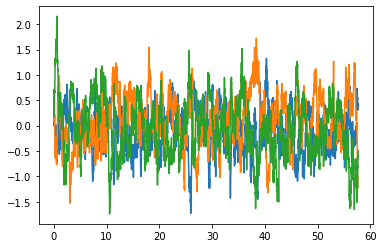

In [ ]:
torch.manual_seed(511)
data_t = TriOU_sample(x0_1*torch.ones(1), x0_2*torch.ones(1), x0_3*torch.ones(1),  obtime, 10,kappa_11*torch.ones(1), kappa_21*torch.ones(1), kappa_22*torch.ones(1), kappa_31*torch.ones(1), kappa_32*torch.ones(1), kappa_33*torch.ones(1) )

#print(data_t)
plt.plot(obtime,torch.Tensor.numpy(data_t[:,0,:])[0,:])
plt.plot(obtime,torch.Tensor.numpy(data_t[:,1,:])[0,:])
plt.plot(obtime,torch.Tensor.numpy(data_t[:,2,:])[0,:])


In [ ]:
L = 70000
Lval = 3000
Ltest = 3000

kappa_11_range = [1, 5]# True kappa = 3
kappa_21_range = [1, 5]# True kappa = 3
kappa_22_range = [1, 5]# True kappa = 3
kappa_31_range = [1, 5]# True kappa = 3
kappa_32_range = [1, 5]# True kappa = 3
kappa_33_range = [1, 5]# True kappa = 3



# Training + Test data generating
torch.manual_seed(510)
kappa_11_ran   = torch.rand(L) * (kappa_11_range[1] - kappa_11_range[0]) + kappa_11_range[0]  
kappa_21_ran   = torch.rand(L) * (kappa_21_range[1] - kappa_21_range[0]) + kappa_21_range[0]  
kappa_22_ran   = torch.rand(L) * (kappa_22_range[1] - kappa_22_range[0]) + kappa_22_range[0]  
kappa_31_ran   = torch.rand(L) * (kappa_31_range[1] - kappa_31_range[0]) + kappa_31_range[0]  
kappa_32_ran   = torch.rand(L) * (kappa_32_range[1] - kappa_32_range[0]) + kappa_32_range[0]  
kappa_33_ran   = torch.rand(L) * (kappa_33_range[1] - kappa_33_range[0]) + kappa_33_range[0]  


# Output: L x 3 matrix
output = torch.stack((kappa_11_ran, kappa_21_ran, kappa_22_ran, kappa_31_ran, kappa_32_ran, kappa_33_ran), dim = 1)
print(output.size())

torch.Size([70000, 6])


In [ ]:
# Generating the y simulated
# It can take about a minute.
torch.manual_seed(2726)

x01_tmp = x0_1 * torch.ones(L)
x02_tmp = x0_2 * torch.ones(L)
x03_tmp = x0_3 * torch.ones(L)

xL = TriOU_sample(x01_tmp, x02_tmp, x03_tmp, obtime, 10, kappa_11_ran, kappa_21_ran, kappa_22_ran, kappa_31_ran, kappa_32_ran, kappa_33_ran)
print(xL.size())

torch.Size([70000, 3, 3001])


In [ ]:
def moment_L(ten):
    """
    X: torch size: [L,n]
    """
    L0 = ten.size()[0]
    n0 = ten.size()[2]

    sum1_1 = torch.zeros(L0) # sum x_{i-1}
    sum1_2 = torch.zeros(L0) # sum x_{i-1}^2
    sum1_3 = torch.zeros(L0) # sum x_{i}^2
    sum1_4 = torch.zeros(L0) # sum x_{i} * x_{i-1}
    sum1_5 = torch.zeros(L0) # sum y_{i-1}
    
    sum2_1 = torch.zeros(L0) # sum y_{i-1}^2
    sum2_2 = torch.zeros(L0) # sum y_{i}
    sum2_3 = torch.zeros(L0) # sum y_{i}^2
    sum2_4 = torch.zeros(L0) # sum y_{i} * y_{i-1}
    sum2_5 = torch.zeros(L0) # sum y_{i} * y_{i-1}
    
    sum3_1 = torch.zeros(L0) # sum z_{i-1}^2
    sum3_2 = torch.zeros(L0) # sum z_{i}
    sum3_3 = torch.zeros(L0) # sum z_{i}^2
    sum3_4 = torch.zeros(L0) # sum z_{i} * z_{i-1}
    sum3_5 = torch.zeros(L0) # sum z_{i} * z_{i-1}
    
    sum12_1 = torch.zeros(L0) # sum_x_{i-1} y_{i-1}
    sum12_2 = torch.zeros(L0) # sum_x_{i} y_{i-1}
    sum12_3 = torch.zeros(L0) # sum x_{i-1} y_i
    sum12_4 = torch.zeros(L0) # sum x_{i} y_{i}
    sum12_5 = torch.zeros(L0) # sum x_{i}^2 y_{i}^2
    sum12_6 = torch.zeros(L0) # sum x_{i-1}^2 y_{i-1}^2
    
    sum23_1 = torch.zeros(L0) # sum_y_{i-1} z_{i-1}
    sum23_2 = torch.zeros(L0) # sum_y_{i} z_{i-1}
    sum23_3 = torch.zeros(L0) # sum y_{i-1} z_i
    sum23_4 = torch.zeros(L0) # sum y_{i} z_{i}
    sum23_5 = torch.zeros(L0) # sum y_{i}^2 z_{i}^2
    sum23_6 = torch.zeros(L0) # sum y_{i-1}^2 z_{i-1}^2
    
    sum13_1 = torch.zeros(L0) # sum_x_{i-1} z_{i-1}
    sum13_2 = torch.zeros(L0) # sum_x_{i} z_{i-1}
    sum13_3 = torch.zeros(L0) # sum x_{i-1} z_i
    sum13_4 = torch.zeros(L0) # sum x_{i} z_{i}
    sum13_5 = torch.zeros(L0) # sum x_{i}^2 z_{i}^2
    sum13_6 = torch.zeros(L0) # sum x_{i-1}^2 z_{i-1}^2
    
    sum123_1 = torch.zeros(L0) # 
    sum123_2 = torch.zeros(L0) # 
    sum123_3 = torch.zeros(L0) # 
    sum123_4 = torch.zeros(L0) # 
    sum123_5 = torch.zeros(L0) # 
    sum123_6 = torch.zeros(L0) # 
    sum123_7 = torch.zeros(L0) # 
    


    for l in range(n0-1):
      sum1_1 = sum1_1 + ten[:,0,l]
      sum1_2 = sum1_2 + torch.pow(ten[:,0,l], 2)
      sum1_3 = sum1_3 + ten[:,0,(l+1)]
      sum1_4 = sum1_4 + torch.pow(ten[:,0,l+1], 2)
      sum1_5 = sum1_5 + ten[:,0,l] * ten[:,0,l+1]
      
      sum2_1 = sum2_1 + ten[:,1,l]
      sum2_2 = sum2_2 + torch.pow(ten[:,1,l], 2)
      sum2_3 = sum2_3 + ten[:,1,(l+1)]
      sum2_4 = sum2_4 + torch.pow(ten[:,1,l+1], 2)
      sum2_5 = sum2_5 + ten[:,1,l] * ten[:,1,l+1]
      
      sum3_1 = sum2_1 + ten[:,2,l]
      sum3_2 = sum2_2 + torch.pow(ten[:,2,l], 2)
      sum3_3 = sum2_3 + ten[:,2,(l+1)]
      sum3_4 = sum2_4 + torch.pow(ten[:,2,l+1], 2)
      sum3_5 = sum2_5 + ten[:,2,l] * ten[:,2,l+1]
      
      sum12_1 = sum12_1 + ten[:,0,l] * ten[:,1,l]
      sum12_2 = sum12_2 + ten[:,0,l+1] * ten[:,1,l]
      sum12_3 = sum12_3 + ten[:,0,l] * ten[:,1,l+1]
      sum12_4 = sum12_4 + ten[:,0,l+1] * ten[:,1,l+1]
      sum12_5 = sum12_5 + torch.pow(ten[:,0,l+1],2) * ten[:,1,l+1]
      sum12_6 = sum12_6 + torch.pow(ten[:,0,l+1],2) * torch.pow(ten[:,1,l+1],2)
      
      sum23_1 = sum23_1 + ten[:,1,l] * ten[:,2,l]
      sum23_2 = sum23_2 + ten[:,1,l+1] * ten[:,2,l]
      sum23_3 = sum23_3 + ten[:,1,l] * ten[:,2,l+1]
      sum23_4 = sum23_4 + ten[:,1,l+1] * ten[:,2,l+1]
      sum23_5 = sum23_5 + torch.pow(ten[:,1,l+1],2) * ten[:,2,l+1]
      sum23_6 = sum23_6 + torch.pow(ten[:,1,l+1],2) * torch.pow(ten[:,2,l+1],2)
      
      sum13_1 = sum13_1 + ten[:,0,l] * ten[:,2,l]
      sum13_2 = sum13_2 + ten[:,0,l+1] * ten[:,2,l]
      sum13_3 = sum13_3 + ten[:,0,l] * ten[:,2,l+1]
      sum13_4 = sum13_4 + ten[:,0,l+1] * ten[:,2,l+1]
      sum13_5 = sum13_5 + torch.pow(ten[:,0,l+1],2) * ten[:,2,l+1]
      sum13_6 = sum13_6 + torch.pow(ten[:,0,l+1],2) * torch.pow(ten[:,2,l+1],2)

      sum123_1 = sum123_1 + ten[:,0,l+1] * ten[:,1,l+1] * ten[:,2,l+1]
      sum123_2 = sum123_2 + ten[:,0,l] * ten[:,1,l+1] * ten[:,2,l+1]
      sum123_3 = sum123_3 + ten[:,0,l+1] * ten[:,1,l] * ten[:,2,l+1]
      sum123_4 = sum123_4 + ten[:,0,l+1] * ten[:,1,l+1] * ten[:,2,l]
      
      sum123_5 = sum123_5 + torch.pow(ten[:,0,l+1],2) * ten[:,1,l+1] * ten[:,2,l+1]
      sum123_6 = sum123_6 + ten[:,0,l+1] * torch.pow(ten[:,1,l+1],2) * ten[:,2,l+1]
      sum123_7 = sum123_7 + ten[:,0,l+1] * ten[:,1,l+1] * torch.pow(ten[:,2,l+1],2)
      
    stack_x = torch.stack((sum1_1/n0, sum1_2/n0, sum1_3/n0, sum1_4/n0, sum1_5/n0),1)
    stack_y = torch.stack((sum2_1/n0, sum2_2/n0, sum2_3/n0, sum2_4/n0, sum2_5/n0),1)
    stack_z = torch.stack((sum3_1/n0, sum3_2/n0, sum3_3/n0, sum3_4/n0, sum3_5/n0),1)
    
    stack_xy = torch.stack((sum12_1/n0, sum12_2/n0, sum12_3/n0, sum12_4/n0, sum12_5/n0, sum12_6/n0), 1)
    stack_yz = torch.stack((sum23_1/n0, sum23_2/n0, sum23_3/n0, sum23_4/n0, sum23_5/n0, sum23_6/n0), 1)
    stack_zx = torch.stack((sum13_1/n0, sum13_2/n0, sum13_3/n0, sum13_4/n0, sum13_5/n0, sum13_6/n0), 1)
    
    stack_xyz = torch.stack((sum123_1/n0, sum123_2/n0, sum123_3/n0, sum123_4/n0, sum123_5/n0, sum123_6/n0, sum123_7/n0 ), 1)
     
    return(torch.cat([stack_x, stack_y, stack_z,stack_xy, stack_yz, stack_zx, stack_xyz], 1))
  
tmp = moment_L(xL)

In [ ]:
import torch
#import torch.nn.functional as F

X = torch.clone(tmp)
X_o = moment_L(data_t)

#X = X.reshape([L,1,n+1])
#output = output.reshape([L,1,p])

print(X.size())
print(X_o.size())
print(output.size())

torch.Size([70000, 40])
torch.Size([1, 40])
torch.Size([70000, 6])


In [ ]:
print(torch.max(tmp), torch.min(tmp))

tensor(577.6761) tensor(-123.9375)


In [ ]:
X_train = tmp[range(0,L-Lval-Ltest),:]
y_train = output[range(0,L-Lval-Ltest),:]

X_val = tmp[range(L-Lval-Ltest,L-Ltest),:]
y_val = output[range(L-Lval-Ltest,L-Ltest),:]

X_test = tmp[range(L-Ltest,L),:]
y_test = output[range(L-Ltest,L),:]



print(X_train.size(), X_val.size(),X_test.size())

torch.Size([64000, 40]) torch.Size([3000, 40]) torch.Size([3000, 40])


In [ ]:
import torch
import torch.optim as optim
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
# N is batch size; 
# D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
# L = 1000 -> H = 64

# Define the batch size
BATCH_SIZE = 64

# Use torch.utils.data to create a DataLoader 
# that will take care of creating batches 
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle=True)

In [ ]:
import torch.nn as nn            # for torch.nn.Module, the parent object for PyTorch models
import torch.nn.functional as F  # for the activation function

# Create the model, loss function, and optimizer
#D_in, H, H2, H3, D_out = 3, 512, 256, 128, p
D_in, H, H2, H3, D_out = X_train.size()[1], 64, 128, 64, p
torch.manual_seed(2726)

#D_in, H, D_out = 3, 512, p

# Dropout rate
p1, p2, p3 = .2, .2, .2
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(D_in, H)
        self.bn1 = nn.BatchNorm1d(num_features=H)
        self.dn1 = nn.Dropout(p1)
        
        self.fc2 = nn.Linear(H, H2)
        self.bn2 = nn.BatchNorm1d(num_features=H2)
        self.dn1 = nn.Dropout(p2)
        
        self.fc3 = nn.Linear(H2, H3)
        self.bn3 = nn.BatchNorm1d(num_features=H3)
        self.dn1 = nn.Dropout(p3)
        
        self.fc4 = nn.Linear(H3, p)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.bn3(self.fc3(x)))
        #x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        #x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

net = Net()

In [ ]:
# Get the dataset size for printing (it is equal to N_SAMPLES)
dataset_size = len(dataloader.dataset)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(net)

20102

In [ ]:
# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
loss_fn = torch.nn.MSELoss(reduction='sum')
learning_rate = 1e-3

optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

N_EPOCHS = 250
train_error_plt = []
val_error_plt = []

results_mat = torch.zeros((int(N_EPOCHS),p))


# Loop over epochs
for epoch in range(N_EPOCHS):
    # Loop over batches in an epoch using DataLoader
    for id_batch, (x_batch, y_batch) in enumerate(dataloader):

        y_batch_pred = net(x_batch)
        loss = loss_fn(y_batch_pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Every 100 batches, print the loss for this batch
        # as well as the number of examples processed so far 
        
        if epoch % 10 ==0 and id_batch % 100 == 0:
            loss, current = loss.item(), (id_batch + 1)* len(x_batch)
            print(f"train_loss: {loss/BATCH_SIZE:>7f}  [{current:>5d}/{dataset_size:>5d}]")
    
    with torch.no_grad():
          #validation loss
           net.eval()
           theta_pred_train = net(X_train)
           train_loss = loss_fn(theta_pred_train,y_train) / (L-Ltest-Lval)
           train_error_plt = np.append(train_error_plt, train_loss)
           
           theta_pred_val = net(X_val)
           val_loss = loss_fn(theta_pred_val,y_val) / (Lval)
           val_error_plt = np.append(val_error_plt, val_loss)
           
    if epoch % 10 ==0:
        print(f"Epoch {epoch + 1}\n-------------------------------")
        print(f"train_loss {train_loss:>7f} val_loss {val_loss:>7f}")

    
    # Choose Best Model
    if val_error_plt[epoch] == np.min(val_error_plt):
         best=epoch
         torch.save(net.state_dict(), path)

    if epoch % 100 ==49:
        learning_rate = max(learning_rate * 1e-1, 1e-9)
    

train_loss: 66.547249  [   64/64000]
train_loss: 4.889184  [ 6464/64000]
train_loss: 2.650658  [12864/64000]
train_loss: 2.321081  [19264/64000]
train_loss: 1.783982  [25664/64000]
train_loss: 2.145384  [32064/64000]
train_loss: 1.592062  [38464/64000]
train_loss: 1.740468  [44864/64000]
train_loss: 1.834638  [51264/64000]
train_loss: 1.821624  [57664/64000]
Epoch 1
-------------------------------
train_loss 2.784724 val_loss 2.450946
train_loss: 0.741321  [   64/64000]
train_loss: 1.089303  [ 6464/64000]
train_loss: 0.938115  [12864/64000]
train_loss: 0.982308  [19264/64000]
train_loss: 1.044332  [25664/64000]
train_loss: 0.969261  [32064/64000]
train_loss: 1.111673  [38464/64000]
train_loss: 1.137485  [44864/64000]
train_loss: 0.950522  [51264/64000]
train_loss: 0.959573  [57664/64000]
Epoch 11
-------------------------------
train_loss 1.152291 val_loss 1.189331
train_loss: 0.927465  [   64/64000]
train_loss: 0.733154  [ 6464/64000]
train_loss: 0.911928  [12864/64000]
train_loss: 0.

0.7038347721099854
174


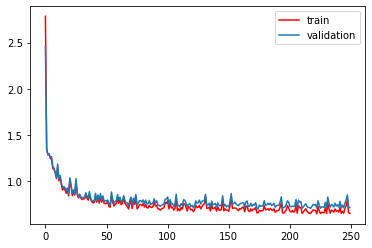

In [ ]:
print(np.min(val_error_plt))
print(np.argmin(val_error_plt))

plt.plot(np.arange(N_EPOCHS), train_error_plt, color = "r")
plt.plot(np.arange(N_EPOCHS), val_error_plt)
plt.legend(["train", "validation"], loc ="upper right")


In [ ]:
net.load_state_dict(torch.load(path))

<All keys matched successfully>

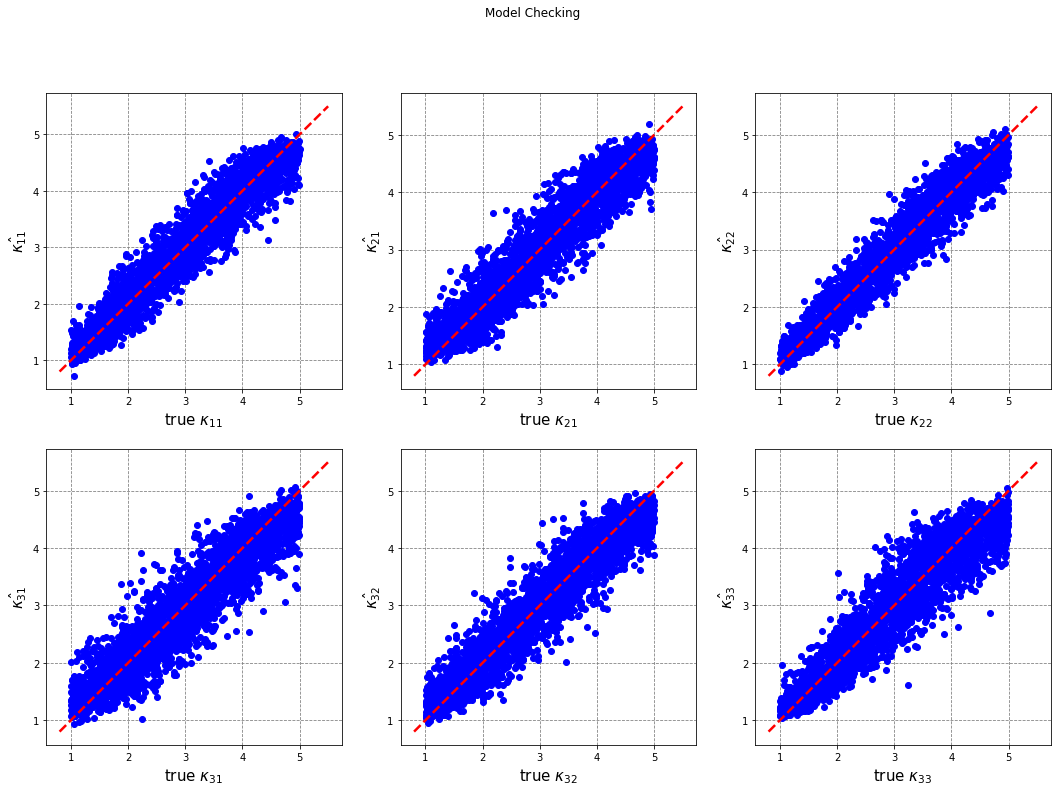

In [ ]:
with torch.no_grad():
  net.eval()
  tmp1 = net(X_test)[:,0]
  tmp2 = net(X_test)[:,1]
  tmp3 = net(X_test)[:,2]
  tmp4 = net(X_test)[:,3]
  tmp5 = net(X_test)[:,4]
  tmp6 = net(X_test)[:,5]

  tmp1 = tmp1.detach().cpu().numpy().tolist()
  tmp2 = tmp2.detach().cpu().numpy().tolist()
  tmp3 = tmp3.detach().cpu().numpy().tolist()
  tmp4 = tmp4.detach().cpu().numpy().tolist()
  tmp5 = tmp5.detach().cpu().numpy().tolist()
  tmp6 = tmp6.detach().cpu().numpy().tolist()




# Plot for model checking
lim1 = [kappa_11_range[0] * 0.8, kappa_11_range[1] * 1.1]
lim2 = [kappa_21_range[0] * 0.8, kappa_21_range[1] * 1.1]
lim3 = [kappa_22_range[0] * 0.8, kappa_22_range[1] * 1.1]
lim4 = [kappa_31_range[0] * 0.8, kappa_31_range[1] * 1.1]
lim5 = [kappa_32_range[0] * 0.8, kappa_32_range[1] * 1.1]
lim6 = [kappa_33_range[0] * 0.8, kappa_33_range[1] * 1.1]

fig, axs = plt.subplots(2, 3, figsize=(18,12))
fig.suptitle('Model Checking')

axs[0,0].scatter(y_test[:,0], tmp1, marker='o', color='b')
axs[0,0].set_xlabel('true $\kappa_{11}$', fontsize=15)
axs[0,0].set_ylabel('$\hat{\kappa_{11}}$', fontsize=15)
axs[0,0].plot(np.linspace(lim1[0], lim1[1], 1000), np.linspace(lim1[0], lim1[1], 1000), color = "red", linestyle='dashed', linewidth = 2.5)
axs[0,0].set_axisbelow(True)
axs[0,0].grid(color='gray', linestyle='dashed')

axs[0,1].scatter(y_test[:,1], tmp2, marker='o', color='b')
axs[0,1].set_xlabel(r'true $\kappa_{21}$', fontsize=15 )
axs[0,1].set_ylabel(r'$\hat{\kappa_{21}}$', fontsize=15)
axs[0,1].plot(np.linspace(lim2[0], lim2[1], 1000), np.linspace(lim2[0], lim2[1], 1000), color = "red", linestyle='dashed', linewidth = 2.5)
axs[0,1].set_axisbelow(True)
axs[0,1].grid(color='gray', linestyle='dashed')

axs[0,2].scatter(y_test[:,2], tmp3, marker='o', color='b')
axs[0,2].set_xlabel('true $\\kappa_{22}$', fontsize=15)
axs[0,2].set_ylabel('$\hat{\\kappa_{22}}$', fontsize=15)
axs[0,2].plot(np.linspace(lim3[0], lim3[1], 1000), np.linspace(lim3[0], lim3[1], 1000), color = "red", linestyle='dashed', linewidth = 2.5)
axs[0,2].set_axisbelow(True)
axs[0,2].grid(color='gray', linestyle='dashed')

axs[1,0].scatter(y_test[:,3], tmp4, marker='o', color='b')
axs[1,0].set_xlabel('true $\\kappa_{31}$', fontsize=15)
axs[1,0].set_ylabel('$\hat{\\kappa_{31}}$', fontsize=15)
axs[1,0].plot(np.linspace(lim4[0], lim4[1], 1000), np.linspace(lim4[0], lim4[1], 1000), color = "red", linestyle='dashed', linewidth = 2.5)
axs[1,0].set_axisbelow(True)
axs[1,0].grid(color='gray', linestyle='dashed')

axs[1,1].scatter(y_test[:,4], tmp5, marker='o', color='b')
axs[1,1].set_xlabel('true $\\kappa_{32}$', fontsize=15)
axs[1,1].set_ylabel('$\hat{\\kappa_{32}}$', fontsize=15)
axs[1,1].plot(np.linspace(lim5[0], lim5[1], 1000), np.linspace(lim5[0], lim5[1], 1000), color = "red", linestyle='dashed', linewidth = 2.5)
axs[1,1].set_axisbelow(True)
axs[1,1].grid(color='gray', linestyle='dashed')

axs[1,2].scatter(y_test[:,5], tmp6, marker='o', color='b')
axs[1,2].set_xlabel('true $\\kappa_{33}$', fontsize=15)
axs[1,2].set_ylabel('$\hat{\\kappa_{33}}$', fontsize=15)
axs[1,2].plot(np.linspace(lim6[0], lim6[1], 1000), np.linspace(lim6[0], lim6[1], 1000), color = "red", linestyle='dashed', linewidth = 2.5)
axs[1,2].set_axisbelow(True)
axs[1,2].grid(color='gray', linestyle='dashed')

plt.show()

In [ ]:
# Test error Calculation

net.eval()
print(torch.sum(torch.pow((net(X_test) - y_test),2))/Ltest)
print(torch.sum(abs(net(X_test) -y_test) )/Ltest)


tensor(0.7053, grad_fn=<DivBackward0>)
tensor(1.5963, grad_fn=<DivBackward0>)


In [ ]:
# Generate the simulation data to get the mean and standard deviation of estimated parameter
sim = 3000 
torch.manual_seed(2072726)

x01_sim = x0_1 * torch.ones(sim)
x02_sim = x0_2 * torch.ones(sim)
x03_sim = x0_3 * torch.ones(sim)

#y0_sim.size()
sim_data1 = TriOU_sample(x01_sim, x02_sim, x03_sim,  obtime, 10, 3 * torch.ones(sim), 2 * torch.ones(sim), 3 * torch.ones(sim), 2 * torch.ones(sim), 4 * torch.ones(sim), 4 * torch.ones(sim))
sim_data1_mom = moment_L(sim_data1) #(3, 2, 3, 2, 4, 4)

sim_data2 = TriOU_sample(x01_sim, x02_sim, x03_sim,  obtime, 10, 2 * torch.ones(sim), 4 * torch.ones(sim), 4 * torch.ones(sim), 2 * torch.ones(sim), 3 * torch.ones(sim), 2 * torch.ones(sim))
sim_data2_mom = moment_L(sim_data2) #(2, 4, 4, 2, 3, 2)

sim_data3 = TriOU_sample(x01_sim, x02_sim, x03_sim,  obtime, 10, 4 * torch.ones(sim), 4 * torch.ones(sim), 4.5 * torch.ones(sim), 3 * torch.ones(sim), 2 * torch.ones(sim), 2.5 * torch.ones(sim))
sim_data3_mom = moment_L(sim_data3) #(4, 4, 4.5, 3, 2, 2.5)
 

In [ ]:
net.eval()
print(torch.mean(net(sim_data1_mom),0),torch.median(net(sim_data1_mom),0),torch.std(net(sim_data1_mom),0)) 
print(torch.mean(net(sim_data2_mom),0),torch.median(net(sim_data2_mom),0),torch.std(net(sim_data2_mom),0)) 
print(torch.mean(net(sim_data3_mom),0),torch.median(net(sim_data3_mom),0),torch.std(net(sim_data3_mom),0))

tensor([3.0189, 2.0515, 3.0136, 2.0156, 3.9821, 4.0236],
       grad_fn=<MeanBackward1>) torch.return_types.median(
values=tensor([2.9876, 2.0277, 2.9854, 1.9974, 3.9989, 4.0667],
       grad_fn=<MedianBackward1>),
indices=tensor([1082, 1047, 1443,  992, 2459, 1566])) tensor([0.3353, 0.3251, 0.3267, 0.3519, 0.3127, 0.3648],
       grad_fn=<StdBackward0>)
tensor([2.0369, 4.0461, 4.0644, 1.9266, 2.8777, 2.0169],
       grad_fn=<MeanBackward1>) torch.return_types.median(
values=tensor([2.0258, 4.0538, 4.0761, 1.8802, 2.8464, 1.9937],
       grad_fn=<MedianBackward1>),
indices=tensor([ 624, 2773, 1584,  680, 1131, 2371])) tensor([0.2849, 0.3151, 0.2913, 0.3390, 0.3450, 0.3302],
       grad_fn=<StdBackward0>)
tensor([4.0413, 3.9492, 4.4072, 2.9790, 2.0315, 2.5899],
       grad_fn=<MeanBackward1>) torch.return_types.median(
values=tensor([4.0607, 3.9821, 4.4568, 2.9831, 2.0167, 2.5706],
       grad_fn=<MedianBackward1>),
indices=tensor([ 958,  338, 1128, 1353,  164, 2632])) tensor([0.3445, 0

In [ ]:
def LSE_TriOU(sim_data):
  A = torch.matmul(sim_data[:,:,1:(n+1)], torch.transpose(sim_data[:,:,0:n],1,2 ))
  B = torch.linalg.inv(torch.matmul(sim_data[:,:,0:n],torch.transpose(sim_data[:,:,0:n],1,2) ))
  Fhat = torch.matmul(A,B)
  diag3 = torch.diag(torch.tensor([1,1,1]))
  Ahat1 = -(Fhat - diag3) / delta_ob
  Ahat2 = -2* torch.matmul((Fhat - diag3), torch.linalg.inv(Fhat + diag3)) / delta_ob
  
  Ahat1 = torch.stack((Ahat1[:,0,0], Ahat1[:,1,0], Ahat1[:,1,1], Ahat1[:,2,0], Ahat1[:,2,1], Ahat1[:,2,2]), 1)
  Ahat2 = torch.stack((Ahat2[:,0,0], Ahat2[:,1,0], Ahat2[:,1,1], Ahat2[:,2,0], Ahat2[:,2,1], Ahat2[:,2,2]), 1)
  
  return([Ahat1,Ahat2])

In [ ]:
net.eval()
param_torch1 = torch.stack((3 * torch.ones(sim), 2 * torch.ones(sim), 3 * torch.ones(sim), 2 * torch.ones(sim), 4 * torch.ones(sim), 4 * torch.ones(sim)), dim=1)
param_torch2 = torch.stack((2 * torch.ones(sim), 4 * torch.ones(sim), 4 * torch.ones(sim), 2 * torch.ones(sim), 3 * torch.ones(sim), 2 * torch.ones(sim)), dim=1)
param_torch3 = torch.stack((4 * torch.ones(sim), 4 * torch.ones(sim), 4.5 * torch.ones(sim), 3 * torch.ones(sim), 2 * torch.ones(sim), 2.5 * torch.ones(sim)), dim=1)

print(torch.sqrt(torch.sum(torch.square(param_torch1 - net(sim_data1_mom))) /sim))
print(torch.sqrt(torch.sum(torch.square(param_torch2 - net(sim_data2_mom))) /sim))
print(torch.sqrt(torch.sum(torch.square(param_torch3 - net(sim_data3_mom))) /sim))

In [ ]:
resultsA1_1, resultsA2_1 = LSE_TriOU(sim_data1)
resultsA1_2, resultsA2_2 = LSE_TriOU(sim_data2)
resultsA1_3, resultsA2_3 = LSE_TriOU(sim_data3)
print(torch.sqrt(torch.sum(torch.square(param_torch1 - resultsA1_1)) /sim) )
print(torch.sqrt(torch.sum(torch.square(param_torch2 - resultsA1_2)) /sim) )
print(torch.sqrt(torch.sum(torch.square(param_torch3 - resultsA1_3)) /sim) )
print(torch.mean(resultsA1_1,0), torch.std(resultsA1_1,0))
print(torch.mean(resultsA1_2,0), torch.std(resultsA1_2,0))
print(torch.mean(resultsA1_3,0), torch.std(resultsA1_3,0))

tensor(0.8946)
tensor(0.8408)
tensor(1.0125)
tensor([2.9857, 1.8950, 2.9731, 1.8130, 3.7685, 3.9153]) tensor([0.3464, 0.3421, 0.3476, 0.3439, 0.3484, 0.3088])
tensor([2.0231, 3.8136, 3.9163, 1.8187, 2.8484, 2.0192]) tensor([0.3491, 0.3348, 0.3207, 0.3394, 0.3255, 0.2251])
tensor([3.9229, 3.7087, 4.3803, 2.7401, 1.8506, 2.5042]) tensor([0.4045, 0.4082, 0.3467, 0.4189, 0.3579, 0.2762])


In [ ]:
print(torch.sqrt(torch.sum(torch.square(param_torch1 - resultsA2_1)) /sim) )
print(torch.sqrt(torch.sum(torch.square(param_torch2 - resultsA2_2)) /sim) )
print(torch.sqrt(torch.sum(torch.square(param_torch3 - resultsA2_3)) /sim) )
print(torch.mean(resultsA2_1,0), torch.std(resultsA2_1,0))
print(torch.mean(resultsA2_2,0), torch.std(resultsA2_2,0))
print(torch.mean(resultsA2_3,0), torch.std(resultsA2_3,0))

tensor(0.9061)
tensor(0.8447)
tensor(0.9996)
tensor([3.0751, 2.0086, 3.0612, 2.0156, 4.0316, 4.0688]) tensor([0.3717, 0.3673, 0.3745, 0.3717, 0.3786, 0.3331])
tensor([2.0645, 4.0418, 4.0700, 2.0045, 3.0185, 2.0593]) tensor([0.3730, 0.3640, 0.3486, 0.3615, 0.3470, 0.2339])
tensor([4.0776, 4.0239, 4.5735, 2.9914, 1.9793, 2.5665]) tensor([0.4450, 0.4510, 0.3785, 0.4542, 0.3836, 0.2904])
